# Computational Genetics: Statistics, Supervised and Unsupervised Learning
**Final Report (using Python)**

Olyssa Sperling

olyssa.sperling@student.hu-berlin.de

[https://github.com/olxssa/Computational_Genomics](https://github.com/olxssa/Computational_Genomics)

Module: Systems Biology: Computational Analysis and Interpretation of High-throughput Data

## Background
### 1) CpG methylation data:
CpG methylation data refers to information about the methylation status of cytosine-guanine dinucleotides (CpG sites) in DNA. DNA methylation is an epigenetic modification where a methyl group is added to the 5th carbon of the cytosine ring, primarily at CpG sites. Methylation patterns are crucial for normal development and cellular differentiation. There are about 24 million CpG dinucleotides in the human genome. Their methylation status can be measured with quantitative assays and the value is between 0 and 1. If it is 0, the CpG is not methylated in any of the cells in the sample, and if it is 1, the CpG is methylated in all the cells of the sample. CpG methylation data is presented as a table with rows as CpG sites and columns as samples. 

### 2) CpG methylation influenced by age:
It was shown that methylation is predictive of the age of the individual (Numata, Ye, Hyde, et al. 2012; Horvath 2013). With age, CpG methylation undergoes a combination of global hypomethylation, localized hypermethylation, and epigenetic drift. These patterns are not just markers of aging but also play active roles in age-related diseases. By studying these changes, researchers can better understand the molecular basis of aging and develop interventions to promote healthy aging.

Key aspects are:

* **Global Hypomethylation**: As individuals age, there is a general loss of methylation across the genome, particularly in repetitive elements and intergenic regions. Hypomethylation in these regions can lead to genomic instability, activation of transposable elements, and inappropriate gene expression


* **Local Hypermethylation**: While global hypomethylation occurs, some specific CpG sites, especially in promoter regions of certain genes, become hypermethylated with age. Hypermethylation often occurs in tumor suppressor genes and pathways involved in cell cycle regulation, contributing to age-related diseases, including cancer.

* **Epigenetic drift**: Epigenetic drift refers to the stochastic (random) changes in DNA methylation patterns that accumulate with age, leading to increased inter-individual variability in methylation profiles over time. This drift is influenced by both genetic and environmental factors, such as diet, smoking, and exposure to pollutants.

* **Age-Associated Differentially Methylated Positions (aDMPs)**: Certain CpG sites show predictable changes in methylation with age, known as age-associated differentially methylated positions (aDMPs). These aDMPs are often enriched in regulatory regions and genes involved in development, such as those in the HOX gene family.

*  **Impact on Health**: 
    * *Cancer*: Age-related methylation changes can lead to hypermethylation of tumor suppressor genes and hypomethylation of oncogenes.
    * *Neurodegeneration*: Methylation changes in genes involved in neuronal function and inflammation contribute to conditions like Alzheimer's disease.
    * *Immune System Decline*: Age-related methylation patterns in immune-related genes contribute to immunosenescence (decline of immune function).

## The dataset
*The dataset contains CpG methylation values per CpG and per individual as a table (“metRmOlWithDbgapId.txt”). Each column is an individual and each row is a CpG, values in the table are methylation values. The subject/sample/individual ids are on the first row. “subjects.txt” has information on the individuals/samples/subjects. The most important attribute here is age. The ids (db gap ids) in this table should match the columns in the first table. There are other attributes such as sex and race.*

## The problem
*The main question is what is the relationship between age and methylation? We explore this with the following tasks.* 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

random_seed = 51

### Task 0
*Read tables and merge them or organize them so that you have an age value for each sample/subject. Your predictive variables are CpG methylation values per sample. Ignore other covariates in “subjects.txt” for simplicity, we only care about age. Age can have minus values if the individual is not born yet.*

In [37]:
### First look into subject data

subjects = pd.read_csv('/Users/olyssa/Downloads/subjects.txt', sep='\t')
subjects.head()

In [38]:
### First look into methylation data

data = pd.read_csv('/Users/olyssa/Downloads/metRmOlWithDbgapId.txt', sep='\t')
data = data.T
data.columns = data.iloc[0]
data = data[1:]
data.head()

In [39]:
### Merge dataframes based on patient db Gap Subject ID

data.insert(0, 'dbGaP ID', list(data.index))
subjects['dbGaP ID'] = subjects['dbGaP ID'].astype('string')
data_merged = pd.merge(subjects, data, on='dbGaP ID', how='left')
print('Number of patients:', len(data_merged))
print('Number of CpG methylation sites:', len(data_merged.columns) - 1)
data_merged = data_merged.drop(labels=['ID', 'dbGaP ID', 'sex', 'Race'], axis=1)
#data_merged.head()

Number of patients: 108
Number of CpG methylation sites: 27582


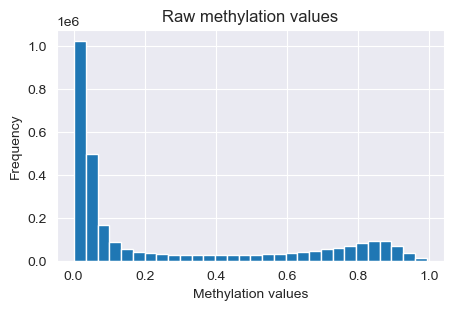

In [9]:
### Plot histogram of methylation values

methylation_values = data_merged.iloc[:, 1:].values.flatten()

fig, ax = plt.subplots(figsize=(5, 3))
plt.hist(methylation_values, bins=30, edgecolor="white")
plt.title("Raw methylation values")
plt.xlabel("Methylation values")
plt.ylabel("Frequency")
plt.show()

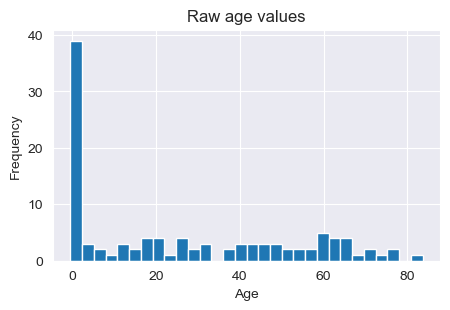

In [10]:
### Plot histogram of age values

fig, ax = plt.subplots(figsize=(5, 3))
plt.hist(data_merged['Age'], bins=30, edgecolor="white")
plt.title("Raw age values")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

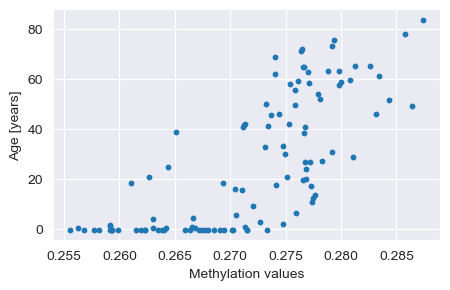

In [11]:
### Take a look if there is a general trend in the data 
# By taking the mean of methylation values over the rows

fig, ax = plt.subplots(figsize=(5, 3))
data_merged_means = data_merged
data_merged_means['methyl_means'] = data_merged_means.iloc[:, 1:].mean(axis=1)  # Take mean over rows
plt.scatter(data_merged_means['methyl_means'], data_merged_means['Age'], s=10)
plt.xlabel('Methylation values')
plt.ylabel('Age [years]')
plt.show()

### Task 1
*Which strategies/methods can be used to test if methylation is predictive of Age in this data set ? List some methods and how they can be used to test this. If possible, give software package names that can be used for the strategies you mention.*

| Method                                | Description                                                                                                                                                                                           | Packages                                                                                 |
|---------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------|
| **Correlation**                       | Using coefficients like Pearson correlation values can be calculated and used to show whether methylation significantly depends on age in a linear manner.                                            | scipy.stats                                                                              |
| **Linear Regression**                 | After fitting a single- or multivariate linear model to the data, p-values and R^2 may evaluate the quality of the model and thereby the significance of the correlation between methylation and age. | sklearn.linear_model, statsmodels                                                        |
| **Principal component analysis (PCA)** | When the dimensionality of the methylation data is reduced, the main components contributing to predicting age can be unraveled.                                                                      | sklearn.decomposition.PCA, statsmodels, sklearn.feature_selection.mutual_info_regression |
| **Random Forest**                     | To account for non-linear relationships in the data a random forest can be trained using methylation values as features and age as target.                                                            |          sklearn.ensemble.RandomForestRegressor                                                                                |
| **Support Vector Machine (SVM)** | Incorporates non-linear relationships using kernel functions as well by training a Support Vector Regression (SVR) model using methylation values as input. | sklearn.svm.SVR |
| **Neural Network (NN)** | Is able to take non-linear relationships into account as well using a multi-layer perceptron (MLP) or deep learning model. But since it requires a large dataset for training, artificial data should be generated in this case before application. | numpy, TensorFlow, PyTorch, keras |


### Task 2: Data processing/preparation tasks

#### Task 2a
*If you want to do some normalization and/or filtering on the variability of predictive features now is the time. Normalization may not be necessary for CpG methylation. The methylation values are bimodal and might be too complicated to first transform them and do normalization (we ideally need some data transformation to make them look more Gaussian). Such transformation & normalization is optional, and may not impact the model performance so much. [Add on: don’t worry about normalization but you might have to do filtering to reduce the number of variables (CpGs) due to limitations in computing power of your workstations but also predictors that are not variable are not likely to impact your model]*

In [12]:
### Check if there are zeros / NaN in the data

print('Count of zeros / NaN in methylation data:', data_merged.iloc[:, 1:].isnull().sum().sum())

Count of zeros / NaN in methylation data: 0


In order to decrease computing time the predictor variables with low variation across samples are removed:

In [13]:
### Remove predictor variables with a low variation across samples

# Ensure all columns are numeric
data_merged_numeric = data_merged.iloc[:, 5:].apply(pd.to_numeric, errors='coerce')

# Convert the dataframe to a NumPy array
data_matrix = data_merged_numeric.to_numpy()

# Calculate standard deviations for each column
column_sds = np.std(data_matrix, axis=0)

# Retain columns with SD > 0.1
filtered_columns = column_sds > 0.1

# Keep the first 5 columns and the filtered columns
data_merged_filtered = data_merged.iloc[:, np.r_[0:4, np.where(filtered_columns)[0]+1]]

# Get the dimensions of the filtered dataset
print('Number of predictor variables before filtering:', len(data_merged.iloc[:, 1:].columns))
print('Number of predictor variables after filtering:', len(data_merged_filtered.iloc[:, 1:].columns))

Number of predictor variables before filtering: 27579
Number of predictor variables after filtering: 2266


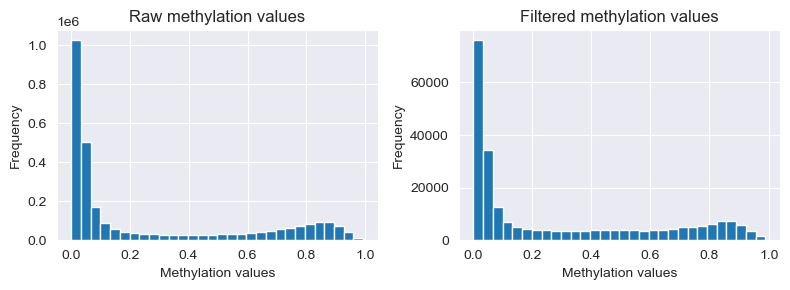

In [14]:
### Histogram comparison of filtered methylation values vs. raw methylation values

# Transform methylation data into flattened array
methylation_values = data_merged.iloc[:, 1:].values.flatten().astype(float)
methylation_values_filtered = data_merged_filtered.iloc[:, 1:].values.flatten().astype(float)

plt.figure(figsize=(8, 3)) 

# First histogram: Raw methylation values
plt.subplot(1, 2, 1)
plt.hist(methylation_values, bins=30)
plt.xlabel("Methylation values")
plt.ylabel("Frequency")
plt.title("Raw methylation values")

# Second histogram: Log-transformed methylation values
plt.subplot(1, 2, 2)
plt.hist(methylation_values_filtered, bins=30)
plt.xlabel("Methylation values")
plt.ylabel("Frequency")
plt.title("Filtered methylation values")

plt.tight_layout()
plt.show()

The shape of the distribution is nearly the same, only the size of the data was reduced to the essence that incorporates the most information about the methylation-age relationship:

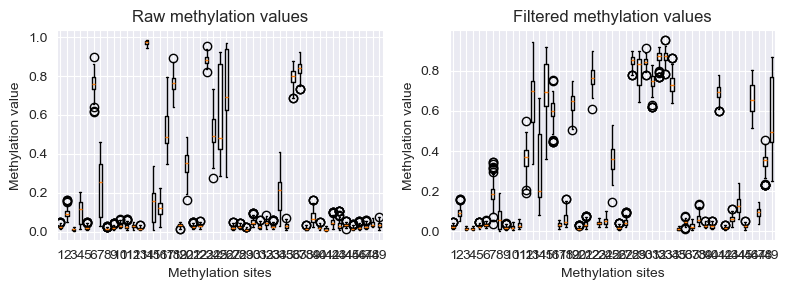

In [15]:
### Barplot comparison of filtered first 50 methylation values vs. raw methylation values

plt.figure(figsize=(8, 3)) 

# First barplot: Raw methylation values
plt.subplot(1, 2, 1)
plt.boxplot(data_merged.iloc[:, 1:50])
plt.xlabel("Methylation sites")
plt.ylabel("Methylation value")
plt.title("Raw methylation values")

# Second barplot: Log-transformed methylation values
plt.subplot(1, 2, 2)
plt.boxplot(data_merged_filtered.iloc[:, 1:50])
plt.xlabel("Methylation sites")
plt.ylabel("Methylation value")
plt.title("Filtered methylation values")

plt.tight_layout()
plt.show()

In order to further decrease computational cost, as a next step highly correlated predictors are filtered out:

In [16]:
### Filter out highly correlated features

# Calculate the correlation matrix
correlation_matrix = data_merged_filtered.corr().abs()

# Identify columns to drop based on the cutoff (0.9 in this case)
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]

# Remove the highly correlated columns
data_merged_filtered_uncorr = data_merged_filtered.drop(columns=to_drop)
# Get the dimensions of the filtered dataset
print('Number of predictor variables before filtering:', len(data_merged_filtered.iloc[:, 1:].columns))
print('Number of predictor variables after filtering:', len(data_merged_filtered_uncorr.iloc[:, 1:].columns))

Number of predictor variables before filtering: 2266
Number of predictor variables after filtering: 1853


#### Task 2b
*Randomly select 10% of the samples as a test set. We do training with cross-validation on the 90% and test performance on the test set.     [Add on: If you can’t figure out how to do this, skip this and rely on CV accuracy only to answer questions]*


In [17]:
### Splitting data into 90 % training and 10 % test

from sklearn.model_selection import train_test_split

training, testing = train_test_split(data_merged_filtered_uncorr, 
                                     test_size=0.1, 
                                     random_state=random_seed)

# Define the feature set (X) and target variable (y) of training set
X_train = training.iloc[:, 1:]  # Features
y_train = training['Age']  # Target variable (continuous)

# Define the feature set (X) and target variable (y) of testing set
X_test = testing.iloc[:, 1:]  # Features
y_test = testing['Age']  # Target variable (continuous)

### Task 3
 *Is methylation predictive of age (previous research indicates so)?  What are the CV performance and test set performance of your model? Pick two strategies you listed for question 1 and implement them to answer this question.*

#### Strategy 1: Random forest

Cross-validation results:
R-squared scores across folds: [0.83025454 0.8898733  0.82617927 0.86544452 0.85646688]
Mean R-squared: 0.854
Standard Deviation of R-squared: 0.023
Mean Squared Error across folds: [113.09472426  79.98176319  97.80892821 115.24585307  74.82301296]
Mean MSE: 96.191 

 Model performance tested on the testing set:
R-squared: 0.865
Mean Squared Error (MSE): 101.186


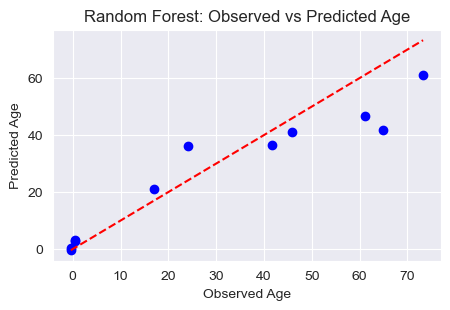

In [18]:
### Training of a random forest model with cross-validation

from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=random_seed)

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=random_seed)

# Cross-validation results
print('\033[1m' + "Cross-validation results:")

# R-squared scores using cross-validation
r2_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='r2')
print('\033[0m' + f"R-squared scores across folds: {r2_scores}")
print(f"Mean R-squared: {r2_scores.mean():.3f}")
print(f"Standard Deviation of R-squared: {r2_scores.std():.3f}")

# Mean Squared Error (MSE)
mse_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring=make_scorer(mean_squared_error))
print(f"Mean Squared Error across folds: {mse_scores}")
print(f"Mean MSE: {mse_scores.mean():.3f} \n")

# Train the model on the entire training set
rf_model.fit(X_train, y_train)

### Testing the model on the testing set

# Predict on the test data
y_pred = rf_model.predict(X_test)

# Calculate R-squared and Mean Squared Error (MSE) on the test set
r2_test_rf = r2_score(y_test, y_pred)
mse_test_rf = mean_squared_error(y_test, y_pred)

# Output test set performance
print('\n \033[1m' + "Model performance tested on the testing set:")
print('\033[0m' + f"R-squared: {r2_test_rf:.3f}")
print(f"Mean Squared Error (MSE): {mse_test_rf:.3f}")

# Plot of observed vs predicted values
fig, ax = plt.subplots(figsize=(5, 3))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Observed Age')
plt.ylabel('Predicted Age')
plt.title('Random Forest: Observed vs Predicted Age')
plt.show()

The CV performance of the RF model with 5-fold split has an $R^2$ mean of 0.821 which indicates that methylation has a strong predictive ability of age. The mean MSE of 111.867 indicates that when predicting age within $\pm$ 10 years the model is acceptable, but for higher precision prediction ($\pm$ 1-2 years) there is room for improvement. On the testing set the model performed very similar but slightly better with a $R^2$ value of 0.899 and an MSE of 101.867.

#### Strategy 2: Neural Network

Cross-validation results:
R-squared scores across folds: [0.83025454 0.8898733  0.82617927 0.86544452 0.85646688]
Mean R-squared: 0.854
Standard Deviation of R-squared: 0.023
Mean Squared Error across folds: [113.09472426  79.98176319  97.80892821 115.24585307  74.82301296]
Mean MSE: 96.191 

 Model performance tested on the testing set:
R-squared: 0.924
Mean Squared Error (MSE): 56.849


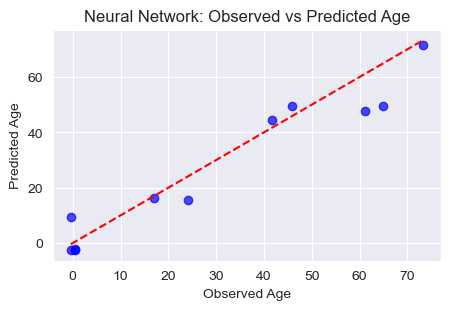

In [19]:
### Predictions of training data by model trained on training data

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Normalize the data (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the neural network model
mlp = MLPRegressor(hidden_layer_sizes=(100,),  # Single hidden layer with 100 neurons
                   activation='relu',          # Activation function
                   solver='adam',              # Optimization algorithm
                   max_iter=500,               # Maximum iterations
                   random_state=random_seed)

# Define cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=random_seed)

# Cross-validation results
print('\033[1m' + "Cross-validation results:")

# R-squared scores using cross-validation
r2_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='r2')
print('\033[0m' + f"R-squared scores across folds: {r2_scores}")
print(f"Mean R-squared: {r2_scores.mean():.3f}")
print(f"Standard Deviation of R-squared: {r2_scores.std():.3f}")

# Mean Squared Error (MSE)
mse_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring=make_scorer(mean_squared_error))
print(f"Mean Squared Error across folds: {mse_scores}")
print(f"Mean MSE: {mse_scores.mean():.3f} \n")

# Train the neural network model
mlp.fit(X_train_scaled, y_train)

### Testing the model on the testing set

# Predict on the test set
y_pred = mlp.predict(X_test_scaled)

# Calculate R-squared and Mean Squared Error (MSE) on the test set
r2_test_nn = r2_score(y_test, y_pred)
mse_test_nn = mean_squared_error(y_test, y_pred)

# Output test set performance
print('\n \033[1m' + "Model performance tested on the testing set:")
print('\033[0m' + f"R-squared: {r2_test_nn:.3f}")
print(f"Mean Squared Error (MSE): {mse_test_nn:.3f}")

# Plot of observed vs predicted values
fig, ax = plt.subplots(figsize=(5, 3))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Observed Age')
plt.ylabel('Predicted Age')
plt.title('Neural Network: Observed vs Predicted Age')
plt.show()

The CV performance of the NN model with 5-fold split has an $R^2$ mean of 0.854 which indicates that methylation has a strong predictive ability of age. The mean MSE of 96.191 indicates that when predicting age within $\pm$ 10 years the model is acceptable, but for higher precision prediction ($\pm$ 1-2 years) there is room for improvement. On the testing set the model performed better with a $R^2$ value of 0.924 and an MSE of 56.849.

### Task 4
*Are all CpGs associated with age? If not, which CpGs are more important for age prediction? Do both methods agree have similar variable importance? Plot importance values as barplots for both methods. [Hint: You need to do some sort of variable importance or variable selection for both methods]*

In [25]:
### Use permutation importance on the trained models

from sklearn.inspection import permutation_importance

# Permutation importance of random forest model
perm_importance_rf = permutation_importance(rf_model, X_test, y_test, 
                                            scoring='r2', 
                                            n_repeats=10,
                                            random_state=random_seed)

perm_df_rf = pd.DataFrame({'Feature': data_merged_filtered_uncorr.columns[1:], 'Importance': perm_importance_rf.importances_mean})
perm_df_rf = perm_df_rf.sort_values(by='Importance', ascending=False)

In [ ]:
### Permutation importance of neural network model
perm_importance_nn = permutation_importance(mlp, X_test, y_test, 
                                            scoring='r2', 
                                            n_repeats=10,
                                            random_state=random_seed)

perm_df_nn = pd.DataFrame({'Feature': data_merged_filtered_uncorr.columns[1:], 'Importance': perm_importance_nn.importances_mean})
perm_df_nn = perm_df_nn.sort_values(by='Importance', ascending=False)

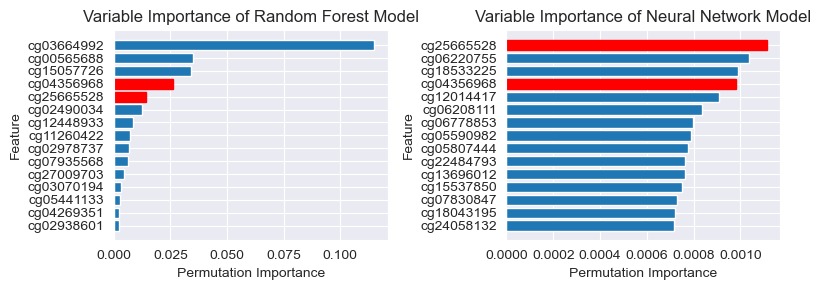

In [27]:
### Find features contained in both 15 first variable importance
same_features = []
for i in range(len(perm_df_rf['Feature'].iloc[:15])):
    f = list(perm_df_rf['Feature'].iloc[:15])[i]
    if f in list(perm_df_nn['Feature'].iloc[:15]):
        same_features.append(f)

# Plot the permutation importances
plt.figure(figsize=(8, 3)) 

plt.subplot(1, 2, 1)
barlist = plt.barh(perm_df_rf['Feature'].iloc[:15], perm_df_rf['Importance'].iloc[:15])
for k in range(len(same_features)):
    barlist[list(perm_df_rf['Feature'].iloc[:15]).index(same_features[k])].set_color('r')
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Variable Importance of Random Forest Model')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
barlist = plt.barh(perm_df_nn['Feature'].iloc[:15], perm_df_nn['Importance'].iloc[:15])
for k in range(len(same_features)):
    barlist[list(perm_df_nn['Feature'].iloc[:15]).index(same_features[k])].set_color('r')
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Variable Importance of Neural Network Model')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [28]:
### Find position of the most important feature of RF in the NN ranking
n = 100
same_features = []
for i in range(len(perm_df_rf['Feature'].iloc[:n])):
    f = list(perm_df_rf['Feature'].iloc[:n])[i]
    if f in list(perm_df_nn['Feature'].iloc[:n]):
        same_features.append(f)
if 'cg03664992' in same_features:
    pos = list(perm_df_nn['Feature'].iloc[:n]).index('cg03664992') + 1
    print(f'Hooray, feature cg03664992 is of importance {pos} for the neural network model.')

Hooray, feature cg03664992 is of importance 78 for the neural network model.


Not all CpG values appear to be associated with age. The two models show a slightly similar importance ranking of variables. Two variables appear in both rankings in the 15 most important ones. Those are "cg04356968" and "cg25665528". "cg25665528" is ranked as the most important variable for the neural network which predicted age slightly better than the random forest. The feature "cg03664992" shows a very high importance for the random forest model. But in the neural network model importance ranking it does not appear until position 78.

### Task 5

#### Task 5a
*Use a sensible cutoff to define “the most important“ using variable importance from both methods. Are you picking the top 10, top 20, or top x percentile? Just define “the top most important”, not really any wrong answers here. Combine the importance metrics from both methods for a unified importance metric, use your imagination here.*

Since the first six features seem to have the most influence in both models and incorporate 2 features contained by both rankings, they are chosen to construct the set of the most important variables:

In [29]:
### Define set of most important variables from both models

most_important_variables_unified = np.unique([*list(perm_df_rf['Feature'].iloc[:6]), 
                                              *list(perm_df_nn['Feature'].iloc[:6])])
print('Number of unified most important variables:', len(most_important_variables_unified))
print(most_important_variables_unified)

Number of unified most important variables: 10
['cg00565688' 'cg02490034' 'cg03664992' 'cg04356968' 'cg06208111'
 'cg06220755' 'cg12014417' 'cg15057726' 'cg18533225' 'cg25665528']


#### Task 5b
*Then, make a heatmap using CpG methylation values for the most important CpGs, but only cluster the CpGs. The sample columns should be sorted by age but not clustered. You might be able to see a visual pattern of CpG methylation values that is associated with the age of the samples on the heatmap. Can you observe such a pattern, display the heatmap as described above, and explain the pattern you see in writing?*


In [30]:
### Create a dataset with the most important variables from both models

important_data = data_merged_filtered_uncorr.loc[:, most_important_variables_unified]
important_data['Age'] = data_merged_filtered_uncorr['Age']

# Sort the samples (columns) by Age
important_data_sorted = important_data.sort_values('Age', ascending=True)

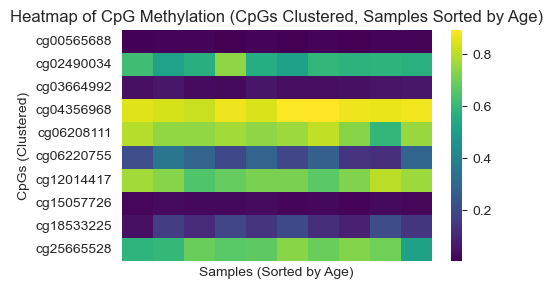

In [31]:
### Heatmap of clustered methylation values and sorted by age

from scipy.cluster.hierarchy import linkage, leaves_list

data_matrix = important_data_sorted.drop(labels=['Age'], axis=1)

# Perform clustering on CpGs (on rows)
linkage_matrix = linkage(data_matrix.T, method='ward')  # Use hierarchical clustering
cluster_order = leaves_list(linkage_matrix)  # Get the order of CpGs based on clustering

# Reorder the data based on clustering for CpGs
clustered_data = data_matrix.T.iloc[:, cluster_order].astype('float')

# Create the heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(clustered_data,
            cmap="viridis", cbar=True, xticklabels=False, yticklabels=True)
plt.title("Heatmap of CpG Methylation (CpGs Clustered, Samples Sorted by Age)")
plt.xlabel("Samples (Sorted by Age)")
plt.ylabel("CpGs (Clustered)")
plt.show()

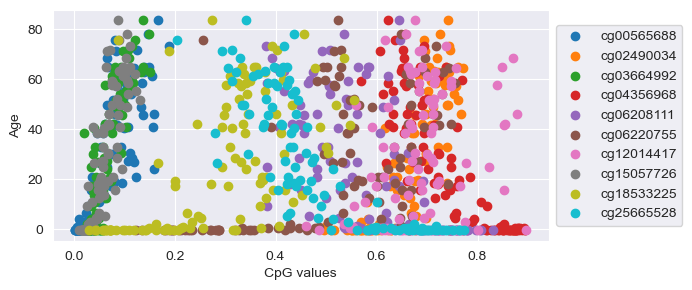

In [32]:
### Scatterplot with most important variables

fig, ax = plt.subplots(figsize=(8, 3))
for i in range(len(important_data_sorted.columns)-1):
    plt.scatter(important_data_sorted.iloc[:, i], important_data_sorted['Age'], label=important_data_sorted.columns[i])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Age")
plt.xlabel("CpG values")
plt.show()

The methylation sites "cg00565688", "cg03664992" and "cg15057726" seem to be the ones most linearly connected to age:

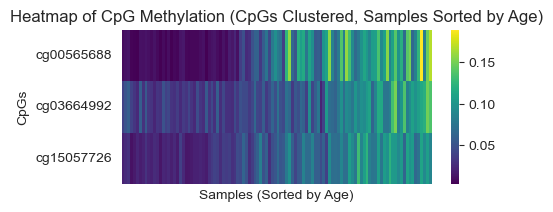

In [33]:
### Create the heatmap of methylation sites "cg00565688", "cg03664992" and "cg15057726"

plt.figure(figsize=(5, 2))
sns.heatmap(data_matrix[['cg00565688', 'cg03664992', 'cg15057726']].astype(float).T,
            cmap="viridis", cbar=True, xticklabels=False, yticklabels=True)
plt.title("Heatmap of CpG Methylation (CpGs Clustered, Samples Sorted by Age)")
plt.xlabel("Samples (Sorted by Age)")
plt.ylabel("CpGs")
plt.show()

Detectable is a general trend that methylation sites gain increased values or have the same values the older the individual. 

### Task 6
*Pick the top 3 most important variables and build a simple linear model with them to predict the age, what is the performance of this model on the test set? Is it better or worse than the initial machine learning models with more variables? Show an accuracy metric on the test set as bar plot.*

Since the methylation sites "cg00565688", "cg03664992" and "cg15057726" seem to be the ones most linearly connected to age, they are picked as the 3 most important variables:

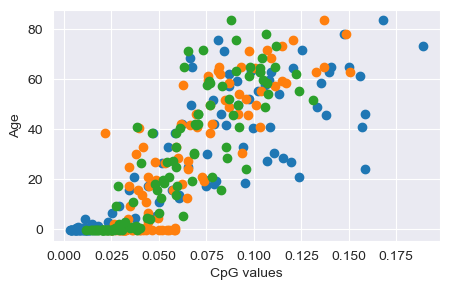

In [34]:
### Create dataframe with 3 most important variables
most_important_three = data_matrix[['cg00565688', 'cg03664992', 'cg15057726']].astype(float)
most_important_three['Age'] = data_merged_filtered_uncorr['Age']

# Plot methylation values of 3 most important variables against age
plt.figure(figsize=(5, 3))
for i in range(3):
    plt.scatter(most_important_three.iloc[:, i], important_data_sorted['Age'], label=important_data_sorted.columns[i])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Age")
plt.xlabel("CpG values")
plt.show()

Mean Squared Error (MSE): 141.10587439290336
R-squared (R²): 0.8522462823852439
Model Coefficients: [130.8346033  312.12664752 326.98990895]
Intercept: -19.819640133296218


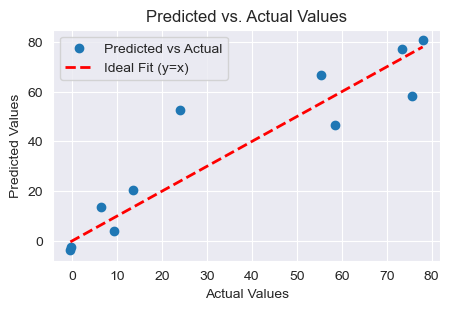

In [35]:
### Construct small multivariate Linear Regression model

from sklearn.linear_model import LinearRegression

X = most_important_three[['cg00565688', 'cg03664992', 'cg15057726']]
y = most_important_three['Age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_seed)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

print("Model Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Scatter plot of actual vs predicted
plt.figure(figsize=(5, 3))
plt.scatter(y_test, y_pred, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ideal Fit (y=x)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Values")
plt.legend()
plt.grid(True)
plt.show()

0.8650849379660639 0.9242009241436165 0.8522462823852439
101.18569568202588 56.84896932155416 141.10587439290336


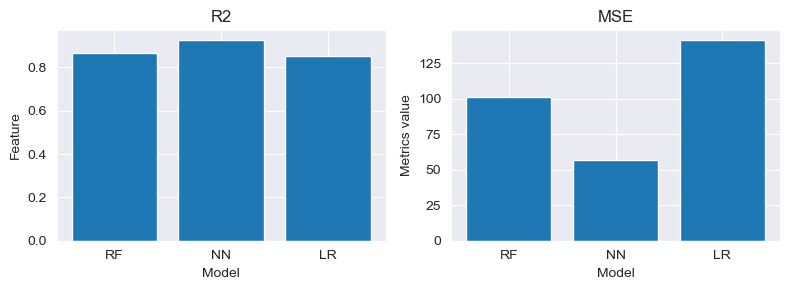

In [36]:
### Compare three age prediction models (RF = Random Forest, NN = Neural Network, LR = Linear Regression)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(r2_test_rf, r2_test_nn, r2)
print(mse_test_rf, mse_test_nn, mse)

# Plot
plt.figure(figsize=(8, 3)) 

plt.subplot(1, 2, 1)
plt.bar(['RF', 'NN', 'LR'], [r2_test_rf, r2_test_nn, r2])
plt.xlabel('Model')
plt.ylabel('Feature')
plt.title('R2')

plt.subplot(1, 2, 2)
plt.bar(['RF', 'NN', 'LR'], [mse_test_rf, mse_test_nn, mse])
plt.xlabel('Model')
plt.ylabel('Metrics value')
plt.title('MSE')

plt.tight_layout()
plt.show()

The Linear Regression model performs worse than the machine learning models. The conclusion can be drawn that age is best predicted with a simple non-linear model rather than a simple multivariate linear model.